In [ ]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

In [ ]:
# Importa las librerias requeridas para el proyecto
import numpy as np
import tensorflow as tf
import sionna

2025-12-13 11:07:24.920590: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 11:07:25.120638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765642045.195087    1115 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765642045.216753    1115 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765642045.359029    1115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Parametros del sistema
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 2 # bits por símbolo (QPSK)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo

In [4]:
class SinCodigCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.generador_rayleigh = sionna.phy.channel.GenerateFlatFadingChannel(num_tx_ant=1, num_rx_ant=1)
        self.awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano
        
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.N])

        # Mapeo
        x = self.mapeador(b)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=1.0)
        no_c = tf.cast(no, tf.complex64)
        h = self.generador_rayleigh(batch_size)
        h_plano = tf.squeeze(h, axis=[1,2])
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = self.awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = self.demapeador(x_eq, no_eff_broadcast)

        return b, llr

In [5]:
# Se inicializa el sistema con los bits congelados aleatorios
canal_rayleigh = SinCodigCanalRayleigh(N, bitsxsimb=bitsxsimb)

I0000 00:00:1765642059.036415    1115 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9579 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.3720e-01 | 9.8500e-01 |       28099 |      204800 |          197 |         200 |         1.4 |reached target block errors
      1.0 | 1.2524e-01 | 9.8500e-01 |       25650 |      204800 |          197 |         200 |         0.0 |reached target block errors
      2.0 | 1.1047e-01 | 9.7000e-01 |       22624 |      204800 |          194 |         200 |         0.0 |reached target block errors
      3.0 | 9.7319e-02 | 9.2000e-01 |       19931 |      204800 |          184 |         200 |         0.0 |reached target block errors
      4.0 | 6.9170e-02 | 8.8000e-01 |       14166 |      204800 |          176 |         200 |         0.0 |reached target block errors
      5.0 | 7.3350e-02 | 8.0500e-01 |       15022 |      204800 |

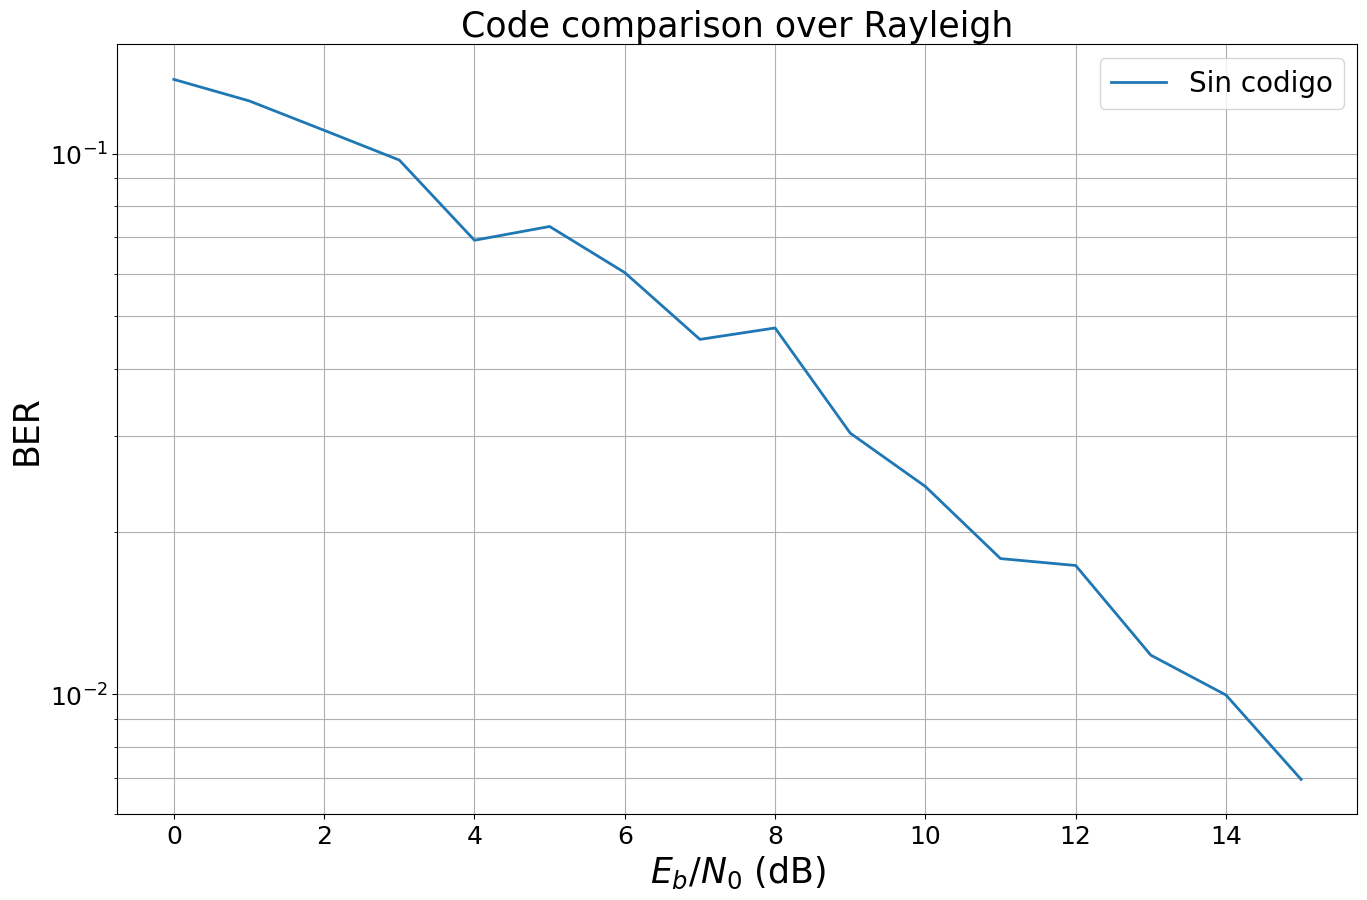

In [6]:
ber_plots = sionna.phy.utils.PlotBER("Code comparison over Rayleigh")
ber_plots.simulate(canal_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);

In [8]:
# Generador Monte Carlo de bits congelados para canal Rayleigh
# Parámetros del sistema
simulaciones = 5000
snr_prueba = 4.0 # Recomendacion paper Sun y Zhang
no = sionna.phy.utils.ebnodb2no(snr_prueba, bitsxsimb, coderate=coderate)
no_c = tf.cast(no, tf.complex64)

# Simulacion Monte Carlo
BER_bits = np.zeros(N)
datos = sionna.phy.mapping.BinarySource()
constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
mapeador = sionna.phy.mapping.Mapper(constellation=constelacion)
demapeador = sionna.phy.mapping.Demapper("app", constellation=constelacion)
generador_rayleigh = sionna.phy.channel.GenerateFlatFadingChannel(num_tx_ant=1, num_rx_ant=1)
awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano

for i in range(N):
    bits_congelados = np.array([j for j in range(N) if j != i])
    codificador = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
    decodificador = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=1)
    
    # Se generan simulaciones sobre el canal Rayleigh
    bits = datos([simulaciones, 1])
    bits_codif = codificador(bits)
    x = mapeador(bits_codif)
    h = generador_rayleigh(simulaciones)
    h_plano = tf.squeeze(h, axis=[1,2])
    y_pre = tf.expand_dims(h_plano, -1) * x
    y = awgn(y_pre, no)
    # Ecualizador ZF
    abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
    zf = tf.math.conj(h_plano) / abs_h2_c
    x_eq = tf.expand_dims(zf, -1) * y
    # Varianza efectiva del ruido
    no_eff = no_c / abs_h2_c
    no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
    no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)
    # Demapeo LLR
    llr = demapeador(x_eq, no_eff_broadcast)
    bits_decodif = decodificador(llr)

    errores = tf.not_equal(bits, bits_decodif)
    BER_bits[i] = tf.reduce_mean(tf.cast(errores, tf.float32))

# Resultados Monte Carlo
indices_ordenados = np.argsort(BER_bits)
bits_congelados = indices_ordenados[-(N-K):]

2025-12-13 11:08:31.038932: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 429.69MiB (rounded to 450560000)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-13 11:08:31.038977: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-12-13 11:08:31.038983: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 33, Chunks in use: 32. 8.2KiB allocated for chunks. 8.0KiB in use in bin. 388B client-requested in use in bin.
2025-12-13 11:08:31.038986: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 768B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-12-13 11:08:31.038

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_3_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[5000,2,11,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [11]:
# Sistema completo de codificación polar con canal Rayleigh
class CodPolarCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, K, bits_congelados, CRC_tipo="CRC24A", lista_SCL=8, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        self.K = K
        self.K_datos = K - 24  # Asumiendo CRC24A
        self.bits_congelados = bits_congelados
        self.CRC_tipo = CRC_tipo
        self.lista_SCL = lista_SCL
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.CRC_codif = sionna.phy.fec.crc.CRCEncoder(CRC_tipo)
        self.polar_codif = sionna.phy.fec.polar.encoding.PolarEncoder(bits_congelados, N)
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.generador_rayleigh = sionna.phy.channel.GenerateFlatFadingChannel(num_tx_ant=1, num_rx_ant=1)
        self.awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano
        self.polar_decodif = sionna.phy.fec.polar.decoding.PolarSCLDecoder(bits_congelados, N, list_size=lista_SCL)
        self.CRC_decodif = sionna.phy.fec.crc.CRCDecoder(crc_encoder=self.CRC_codif)
        
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.K_datos])
        data_con_crc = self.CRC_codif(b)
        bits_codif = self.polar_codif(data_con_crc)

        # Mapeo
        x = self.mapeador(bits_codif)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=self.K/self.N)
        no_c = tf.cast(no, tf.complex64)
        h = self.generador_rayleigh(batch_size)
        h_plano = tf.squeeze(h, axis=[1,2])
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = self.awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = self.demapeador(x_eq, no_eff_broadcast)

        # Decodificación
        words_decodif = self.polar_decodif(llr)
        b_hat, crc_ok = self.CRC_decodif(words_decodif)
        
        return b, b_hat, llr, crc_ok

In [13]:
# Se inicializa el sistema con los bits congelados obtenidos por Monte Carlo para canal Rayleigh
sistema_rayleigh = CodPolarCanalRayleigh(N, K, bits_congelados, bitsxsimb=bitsxsimb)

/home/sergio/miniconda3/envs/tf/lib/python3.12/site-packages/sionna/phy/fec/polar/decoding.py:415: UserWarning: Required resource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required resource allocation is large " \


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.4029e-01 | 7.2286e-01 |      116242 |      341600 |          506 |         700 |        54.8 |reached target block errors
      1.0 | 2.9159e-01 | 6.1667e-01 |      128066 |      439200 |          555 |         900 |        66.3 |reached target block errors
      2.0 | 2.4477e-01 | 5.2900e-01 |      119449 |      488000 |          529 |        1000 |        73.2 |reached target block errors
      3.0 | 2.1793e-01 | 4.7364e-01 |      116987 |      536800 |          521 |        1100 |        81.2 |reached target block errors
      4.0 | 1.7734e-01 | 3.8615e-01 |      112504 |      634400 |          502 |        1300 |        96.5 |reached target block errors
      5.0 | 1.4769e-01 | 3.2125e-01 |      115316 |      780800 |

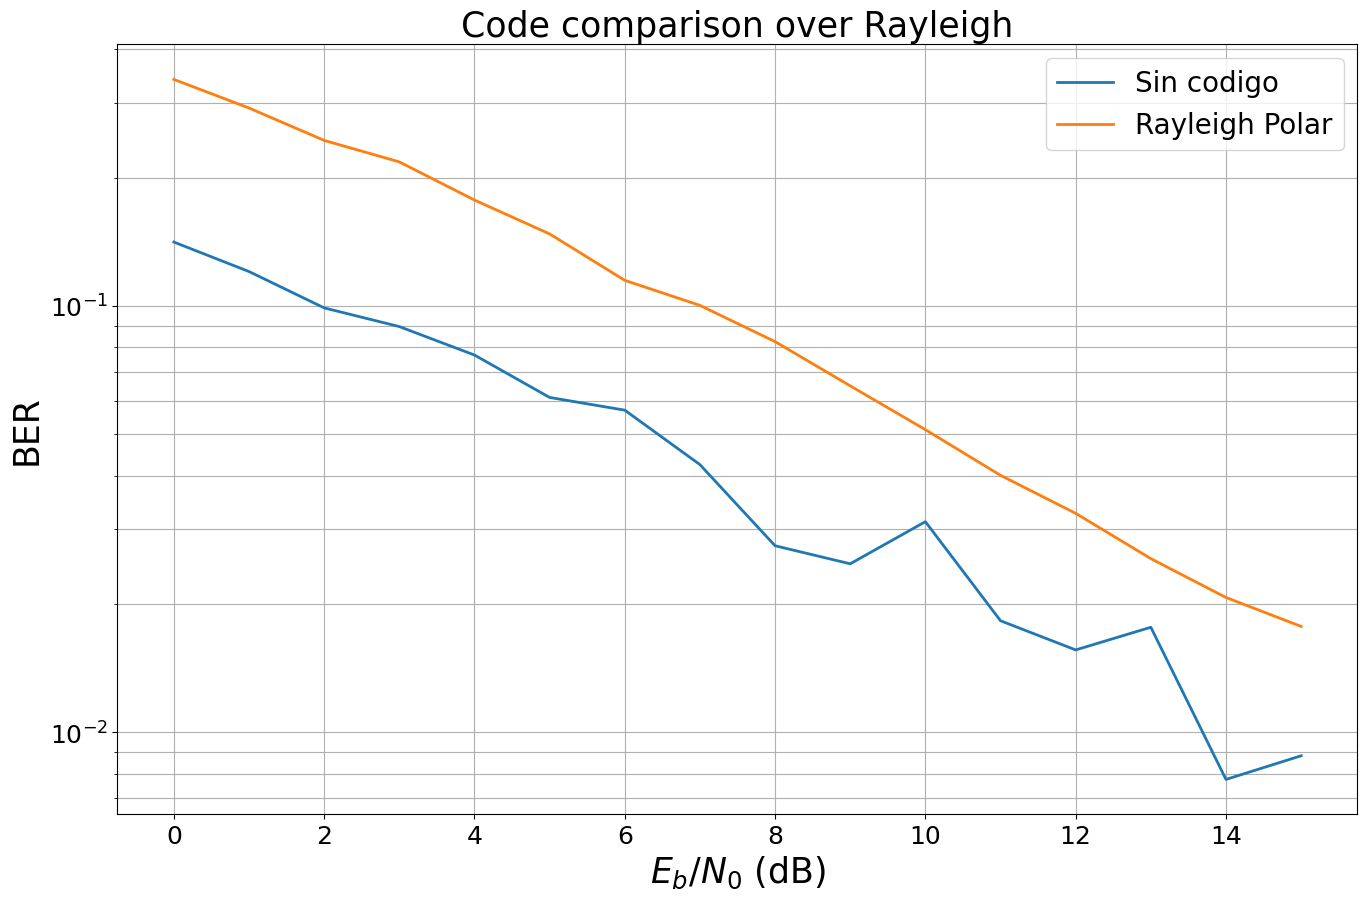

In [14]:
# Ploteo de la tasa de error para Rayleigh Polar
ber_plots.simulate(sistema_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=500,
                   legend="Rayleigh Polar",
                   soft_estimates=False,
                   max_mc_iter=25,
                   show_fig=True,
                   forward_keyboard_interrupt=False);